# Sersic Fitting Measurement

In [1]:
#check what you actually use, delete unused imports
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
#from matplotlib.patches import Circle
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.functional_models import Sersic2D
from reproject import reproject_interp
from astropy.cosmology import FlatLambdaCDM
from pylab import contour, savefig
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import LogStretch, ManualInterval, ImageNormalize, PowerStretch
import math
import emcee
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from importlib import reload

In [2]:
import KnotFit as kf

In [3]:
indir = 'whl0137'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz.fits' 
imfile = os.path.join(indir,imfile)
modeldir = 'whl0137/testruns/z6twopt'
dflx = os.path.join(modeldir, 'dx_z6.fits')
dfly = os.path.join(modeldir, 'dy_z6.fits')

ax, ay, imdataHST = kf.initDeflection_Image(imfile, dflx, dfly, 
                                         zlens=0.566, zsource_in=6.0, zsource_out=6.2)
    
magnifinv = kf.makeMagnificationMap(ax, ay)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


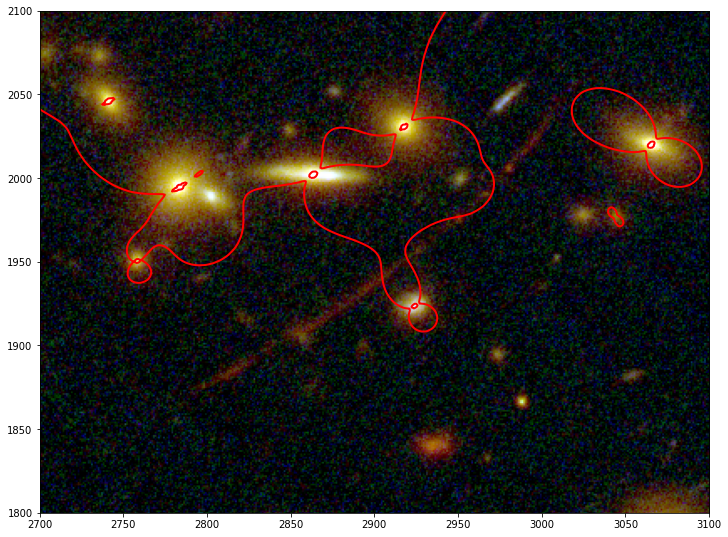

In [5]:
infile = 'whl0137-08_new_bright.png'
infile = os.path.join(indir, infile)
im = Image.open(infile)
im = im.transpose(Image.FLIP_TOP_BOTTOM)

# Define coordinate grid
yy, xx = np.indices(magnifinv.shape)

plt.figure(figsize=(12, 12.5))
plt.imshow(im, origin='lower')
xlo, xhi = 2700, 3100
ylo, yhi = 1800, 2100
#xlo, xhi = 1800, 3300
#ylo, yhi = 1700, 3200
plt.xlim(xlo, xhi)
plt.ylim(ylo, yhi)
con = plt.contour(xx, yy, magnifinv, [0], colors='r', linewidths=2)

In [6]:
# Source position grid
xss = xx - ax
yss = yy - ay

xlo, xhi = 2700, 3100
ylo, yhi = 1800, 2100

imstamp = imdataHST[ylo:yhi, xlo:xhi]

star = kf.starGen(imdataHST, starLoc=(2232, 1622))

#knotpos = (2950, 1976) # lower knot
knotpos = (2981, 2006) # upper knot
x, y = knotpos
knotmag = 1. / magnifinv[x,y]

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
rmsfile = os.path.join(indir, rmsfile)
argdict = kf.initArgDict(rmsfile, imstamp, limits=(xlo,xhi,ylo,yhi), ax=ax, ay=ay,
                      knotpos=knotpos, sourcegrid=(xss,yss), star=star, magnification=knotmag)

#print(argdict)

/home/brian/Documents/JHU/lensing/knotfit/KnotFit.py:302: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  flux_eps[ix] = 0. # remove zeros to avoid nans in sqrt


In [7]:
theta = np.array([.001, 450])#, x, y])

sampler = kf.runMCMC(theta, argdict, nwalkers=8, niter=10)

100%|██████████| 10/10 [02:30<00:00, 15.02s/it]


In [8]:
samples = sampler.get_chain(flat=True)
#tau = sampler.get_autocorr_time()
#print(tau)
print(np.median(samples[:,0]))
print(np.median(samples[:,1]))

0.0009914052839814214
450.00000464495497


In [9]:
mcmcfile = 'knotfit/chains/lowknot_mcmc_loglhood_5kstep_4walk.h5'
#mcmcfile = 'knotfit/chains/topknot_5k_4walk.h5'
reader = emcee.backends.HDFBackend(mcmcfile)
#tau = reader.get_autocorr_time()
#print(tau)
samples = reader.get_chain(flat=True)
print(samples.shape)
print(np.median(samples[:,0]))
print(np.median(samples[:,1]))
#print(np.median(samples[:,2]))
#print(np.median(samples[:,3]))

(20000, 2)
0.0004984463643216413
2.0335324781115673


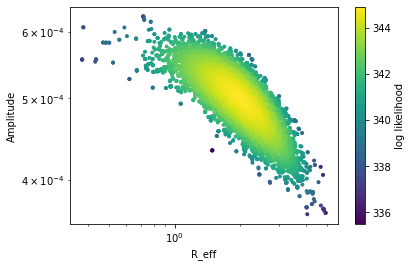

In [10]:
amp = samples[250:,0]
reff = samples[250:,1]
lprob = reader.get_log_prob(flat=True)
#lprob = sampler.get_log_prob(flat=True)
lprob = lprob[250:]

fig = plt.figure()

plt.scatter(reff, amp, c=lprob, marker='.')
cb = plt.colorbar(label='log likelihood')
#plt.plot(450, 0.0007, 'ro')
plt.loglog()
plt.xlabel('R_eff')
plt.ylabel('Amplitude')

plt.show()

In [13]:
med_r = np.median(reff)
sigplus = np.percentile(reff, 84)
sigminus = np.percentile(reff, 16)
sig = (sigplus - sigminus) / 2.
print('reff = %.2f +- %.2f pixels' % (med_r, sig))
print('reff = %.2f +- %.2f pc' % (kf.pix_to_pc(med_r,6.2,knotmag), kf.pix_to_pc(sig,6.2,knotmag)))

reff = 2.04 +- 0.50 pixels
reff = 225.98 +- 55.23 pc


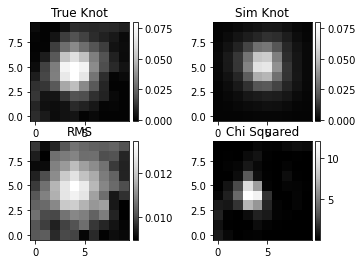

Total Chi-Squared: 90.31


In [12]:
theta = [np.median(samples[:,0]), np.median(samples[:,1])]#, np.median(samples[:,2]), np.median(samples[:,3])] 

cv = kf.convolved(theta,**argdict)
arcimage = argdict["arcIm"]

simimage = np.zeros_like(arcimage)
simimage[:,:] += cv[:,:]

TB = argdict["knotbounds"]
SB = argdict["knotbounds"]
tK = arcimage[TB[2]:TB[3], TB[0]:TB[1]]
sK = simimage[SB[2]:SB[3], SB[0]:SB[1]]

sigma = argdict['sigma']

Xsq = (tK - sK)**2 * (1/sigma**2) 

norm = ImageNormalize(stretch=LogStretch())

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2, 2)


im1 = ax1.imshow(tK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('True Knot')

im2 = ax2.imshow(sK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Sim Knot')

im3 = ax3.imshow(sigma, origin='lower', cmap='Greys_r')

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('RMS')

im4 = ax4.imshow(Xsq, origin='lower', cmap='Greys_r')

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_title('Chi Squared')

plt.show()

print('Total Chi-Squared: %.2f' %np.sum(Xsq))

# Initial FWHM Calculation:

In [14]:
import numpy as np
from scipy import integrate
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [15]:
def init(filename, bandpass):
    knot = Table.read(filename, format='ascii')
    mag = np.array(knot[bandpass])
    fwhm = np.array(knot['fwhm'])
    return mag, fwhm


def SFR(L_uv, lam):
    ### Assumes lam in Angstroms, L_uv in erg/s, SFR in Msun/yr
    const = 3. * 10**(-47) #constant from Calzetti 2013
    sfr = const * lam * L_uv 
    return sfr

def L_from_m(mag, z):
    #Mag_sol = 4.52 #f110w, http://mips.as.arizona.edu/~cnaw/sun.html 
    Mag_sol = 4.60 #f160w
    Lsol_erg = 3.826 * 10**33 #erg/s, https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/units.html
    dist_pc = DL(0,z) * 10**6
    Mag = mag - 5*np.log10(dist_pc / 10.)
    #print(Mag)
    L_Lsol = 10**((Mag_sol - Mag) / 2.5)
    #print(L_Lsol)
    L_erg = L_Lsol * Lsol_erg
    return L_erg


def phys_radius_pc(fwhm, mu, z):
    kpc_arcmin = cosmo.kpc_proper_per_arcmin(z)
    kpc_arcsec = (kpc_arcmin*u.arcmin) / (60. * u.arcsec)
    print(kpc_arcsec)
    size_demag = fwhm / np.sqrt(mu)
    radius_kpc = (size_demag/2.) * kpc_arcsec.value
    return radius_kpc * 1000.


def main_measures(filename, bandpass, mu, z):
    mag, fwhm = init(filename, bandpass)
    mag_intrinsic = mag + 2.5 * np.log10(mu)
    lam_obs = int(bandpass[1:4]) * 100 #16000
    lam_emit = lam_obs / (1+z)
    
    LUV = L_from_m(mag_intrinsic,z)
    sfr = SFR(LUV,lam_emit)
    
    radius_pc = phys_radius_pc(fwhm, mu, z)
    print(mag, fwhm, sfr, radius_pc)
    return


#################################
# Cosmology

h = 0.7  # Hubble constant / (100 km/s/Mpc)
Om = 0.3  # Omega matter
OL = 1 - Om  # Omega Lambda

H100 = 3.24077674937e-18  # 100 km/s/Mpc in units of 1 / S (inverse seconds)
c_mpc = 9.7155e-15  # MPC / S

def H(z):
    """Hubble constant [1/S] at redshift z for a flat universe"""
    return h * H100 * np.sqrt(Om * (1+z)**3 + OL)

def Hinv(z):
    return 1 / H(z)

def DA(z1, z2):
    """Angular-diameter distance (MPC)
    between two redshifts for a flat universe"""
    #return c / (1.+z2) * integral(lambda z: 1/H(z), z1, z2)
    return c_mpc / (1.+z2) * integrate.quad(Hinv, z1, z2)[0]

def DL(z1, z2):
    return c_mpc * (1+z2) * integrate.quad(Hinv, z1, z2)[0]

In [16]:
# z = 6
files = ['whl0137/z6_segfiles/1291.cat', 
        'whl0137/z6_segfiles/1349.cat']
magnifications = [126, 409]

[main_measures(files[i], 'f110w_mag', magnifications[i], 6.2) for i in range(len(files))]

5.608569531447217 kpc / arcsec
[26.2012] [0.223] [0.11453837] [55.7110961]
5.608569531447217 kpc / arcsec
[26.3485] [0.407] [0.03080905] [56.43582367]


[None, None]